# Lecture 4: ML WorkFlow and `sklearn` pipelines


Instructor: Amna Mazen

## Imports

In [ ]:
import sys
import time

import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np
import pandas as pd
from IPython.display import HTML


from IPython.display import display
#from plotting_functions import *

# Classifiers and regressors
from sklearn.dummy import DummyClassifier, DummyRegressor

# Preprocessing and pipeline
from sklearn.impute import SimpleImputer

# train test split and cross validation
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
#from utils import *

pd.set_option("display.max_colwidth", 200)

## Data Splitting


- Keep aside some randomly selected portion from the training data.
- `fit` (train) a model on the training portion only.
- `score` (assess) the trained model on this set aside data to get a sense of how well the model would be able to generalize.
- Pretend that the kept aside data is representative of the real distribution $D$ of data.

- We can pass `X` and `y` or a dataframe with both `X` and `y` in it.
- We can also specify the train or test split sizes.

### Simple Random Sampling (SRS)

#### scikit-learn train_test_split


In [ ]:
url = "https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html"
HTML("<iframe src=%s width=1000 height=800></iframe>" % url)

/usr/local/lib/python3.11/dist-packages/IPython/core/display.py:724: UserWarning: Consider using IPython.display.IFrame instead
  warnings.warn("Consider using IPython.display.IFrame instead")


In [ ]:


import pandas as pd
from sklearn import datasets

iris = datasets.load_iris()
iris_df=pd.DataFrame(iris.data)

iris_df['class']=iris.target
iris_df.columns=['sepal_len', 'sepal_wid', 'petal_len', 'petal_wid', 'class']


X = iris_df.iloc[:,:-1]
y = iris_df.iloc[:,-1]

iris_df['class'].value_counts()


,count
class,
0,50
1,50
2,50


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size=0.8,
                                                   random_state=None,
                                                   shuffle=True, stratify=None)

print("Class distribution of train set")
print(y_train.value_counts())
print()
print("Class distribution of test set")
print(y_test.value_counts())

Class distribution of train set
class
0    41
1    40
2    39
Name: count, dtype: int64

Class distribution of test set
class
2    11
1    10
0     9
Name: count, dtype: int64


### Stratified sampling

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test= train_test_split(X,y, train_size=0.8,
                                                   random_state=None,
                                                   shuffle=True, stratify=y)
print(y_train.value_counts())
print(y_test.value_counts())

class
1    40
0    40
2    40
Name: count, dtype: int64
class
0    10
1    10
2    10
Name: count, dtype: int64


### Train/validation/test split

- Some of you may have heard of "validation" data.
- Sometimes it's a good idea to have a separate data for hyperparameter tuning.

![](img/train-valid-test-split.png)

<!-- <img src='img/train-valid-test-split.png' width="1500" height="1500" /> -->

## Cross Validation

```{important}
Keep in mind that cross-validation does not return a model. It is not a way to build a model that can be applied to new data. The purpose of cross-validation is to **evaluate** how well the model will generalize to unseen data.
```

In [ ]:
! pip install mglearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 581.4/581.4 kB 11.1 MB/s eta 0:00:00


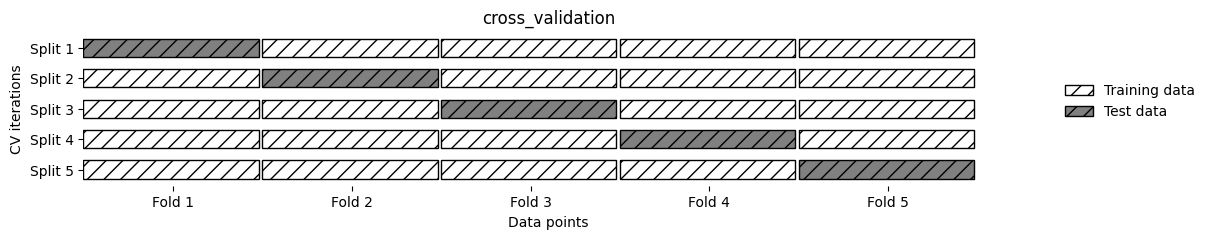

In [ ]:
import mglearn
mglearn.plots.plot_cross_validation()

#### Our typical supervised learning set up is as follows:

- We are given training data with features `X` and target `y`
- We split the data into train and test portions: `X_train, y_train, X_test, y_test`
- We carry out hyperparameter optimization using cross-validation on the train portion: `X_train` and `y_train`.
- We assess our best performing model on the test portion: `X_test` and `y_test`.  
- What we care about is the **test error**, which tells us how well our model can be generalized.
- If this test error is "reasonable" we deploy the model which will be used on new unseen examples.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
model = DecisionTreeClassifier(max_depth=10)
scores = cross_validate(model, X_train, y_train, cv=10, return_train_score=True)
pd.DataFrame(scores)

,fit_time,score_time,test_score,train_score
0,0.013394,0.007290,1.000000,1.0
1,0.007419,0.010016,1.000000,1.0
2,0.008404,0.008292,0.818182,1.0
3,0.010340,0.007370,1.000000,1.0
4,0.011567,0.016585,0.636364,1.0
5,0.018288,0.012802,0.818182,1.0
6,0.021302,0.008298,1.000000,1.0
7,0.008406,0.006227,0.909091,1.0
8,0.013733,0.006610,0.909091,1.0
9,0.014374,0.005015,0.909091,1.0


- How do we know whether this test score is reasonable?

- We will try to use "validation" to refer to data where we have access to the target values.
  - But, unlike the training data, we only use this for hyperparameter tuning and model assessment; we don't pass these into `fit`.  
- We will try to use "test" to refer to data where we have access to the target values
  - But, unlike training and validation data, we neither use it in training nor hyperparameter optimization.
  - We only use it **once** to evaluate the performance of the best performing model on the validation set.   
  - We lock it in a "vault" until we're ready to evaluate.

Note that there isn't good concensus on the terminology of what is validation and what is test.

## Pipeline and Column Transformer in `sklearn` on the California housing dataset

We'll be working on [California housing prices regression dataset](https://raw.githubusercontent.com/MazenMTULab/ML_COURSE_RESOURCES/refs/heads/main/Dataset/Lecture_Dataset/housing.csv) to demonstrate these feature transformation techniques. The task is to predict median house values in Californian districts, given a number of features from these districts. If you are running the notebook on your own, you'll have to download the data and put it in the data directory.

We have one categorical feature and all other features are numeric features.

In [ ]:
housing_df = pd.read_csv("https://raw.githubusercontent.com/MazenMTULab/ML_COURSE_RESOURCES/refs/heads/main/Dataset/Lecture_Dataset/housing.csv")
train_df, test_df = train_test_split(housing_df, test_size=0.1, random_state=123)

train_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN


In [ ]:
housing_df["total_bedrooms"].isnull().sum()

207

In [ ]:
train_df = train_df.assign(
    rooms_per_household=train_df["total_rooms"] / train_df["households"]
)
test_df = test_df.assign(
    rooms_per_household=test_df["total_rooms"] / test_df["households"]
)

train_df = train_df.assign(
    bedrooms_per_household=train_df["total_bedrooms"] / train_df["households"]
)
test_df = test_df.assign(
    bedrooms_per_household=test_df["total_bedrooms"] / test_df["households"]
)

train_df = train_df.assign(
    population_per_household=train_df["population"] / train_df["households"]
)
test_df = test_df.assign(
    population_per_household=test_df["population"] / test_df["households"]
)

In [ ]:
train_df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,2948.0,636.0,2600.0,602.0,3.1250,113600.0,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,346.0,130.0,51.0,20.0,3.4861,137500.0,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,3355.0,768.0,1457.0,708.0,2.6604,170100.0,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,1634.0,274.0,899.0,285.0,5.2139,129300.0,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,5566.0,1465.0,6303.0,1458.0,1.8580,205000.0,NEAR OCEAN,3.817558,1.004801,4.323045
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,726.0,NaN,490.0,130.0,3.6389,167600.0,<1H OCEAN,5.584615,NaN,3.769231
15377,-117.24,33.37,14.0,4687.0,793.0,2436.0,779.0,4.5391,180900.0,<1H OCEAN,6.016688,1.017972,3.127086
17730,-121.76,37.33,5.0,4153.0,719.0,2435.0,697.0,5.6306,286200.0,<1H OCEAN,5.958393,1.031564,3.493544
15725,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,412500.0,NEAR BAY,4.739264,1.024540,1.720859


In [ ]:
# Let's keep both numeric and categorical columns in the data.
X_train = train_df.drop(columns=["median_house_value", "total_rooms", "total_bedrooms", "population"])
y_train = train_df["median_house_value"]

X_test = test_df.drop(columns=["median_house_value", "total_rooms", "total_bedrooms", "population"])
y_test = test_df["median_house_value"]

In [ ]:
from sklearn.compose import ColumnTransformer, make_column_transformer


In [ ]:
X_train.head(10)


,longitude,latitude,housing_median_age,households,median_income,ocean_proximity,rooms_per_household,bedrooms_per_household,population_per_household
6051,-117.75,34.04,22.0,602.0,3.1250,INLAND,4.897010,1.056478,4.318937
20113,-119.57,37.94,17.0,20.0,3.4861,INLAND,17.300000,6.500000,2.550000
14289,-117.13,32.74,46.0,708.0,2.6604,NEAR OCEAN,4.738701,1.084746,2.057910
13665,-117.31,34.02,18.0,285.0,5.2139,INLAND,5.733333,0.961404,3.154386
14471,-117.23,32.88,18.0,1458.0,1.8580,NEAR OCEAN,3.817558,1.004801,4.323045
9730,-121.74,36.79,16.0,611.0,4.3814,<1H OCEAN,6.286416,1.014730,2.944354
14690,-117.09,32.80,36.0,360.0,4.7188,NEAR OCEAN,6.008333,1.019444,2.541667
7938,-118.11,33.86,33.0,393.0,5.3889,<1H OCEAN,6.078880,1.043257,3.127226
18365,-122.12,37.28,21.0,56.0,5.8691,<1H OCEAN,6.232143,1.142857,2.660714
10931,-117.91,33.74,25.0,922.0,2.9926,<1H OCEAN,4.634490,1.046638,3.195228


In [ ]:
X_train.columns


Index(['longitude', 'latitude', 'housing_median_age', 'households',
       'median_income', 'ocean_proximity', 'rooms_per_household',
       'bedrooms_per_household', 'population_per_household'],
      dtype='object')

In [ ]:
# Identify the categorical and numeric columns
numeric_features = [
    "longitude",
    "latitude",
    "housing_median_age",
    "households",
    "median_income",
    "rooms_per_household",
    "bedrooms_per_household",
    "population_per_household",
]

categorical_features = ["ocean_proximity"]
target = "median_income"

- Let's create a ColumnTransformer for our dataset.


In [ ]:
X_train.info()


<class 'pandas.core.frame.DataFrame'>
Index: 18576 entries, 6051 to 19966
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   longitude                 18576 non-null  float64
 1   latitude                  18576 non-null  float64
 2   housing_median_age        18576 non-null  float64
 3   households                18576 non-null  float64
 4   median_income             18576 non-null  float64
 5   ocean_proximity           18576 non-null  object 
 6   rooms_per_household       18576 non-null  float64
 7   bedrooms_per_household    18391 non-null  float64
 8   population_per_household  18576 non-null  float64
dtypes: float64(8), object(1)
memory usage: 1.4+ MB


In [ ]:
X_train["ocean_proximity"].value_counts()


,count
ocean_proximity,
<1H OCEAN,8221
INLAND,5915
NEAR OCEAN,2389
NEAR BAY,2046
ISLAND,5


In [ ]:
numeric_transformer = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [ ]:
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

In [ ]:
preprocessor = make_column_transformer(
    (numeric_transformer, numeric_features),
    (categorical_transformer, categorical_features),
)

In [ ]:
preprocessor

ColumnTransformer(transformers=[('pipeline',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['longitude', 'latitude', 'housing_median_age',
                                  'households', 'median_income',
                                  'rooms_per_household',
                                  'bedrooms_per_household',
                                  'population_per_household']),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['ocean_proximity'])])

In [ ]:
X_train_pp = preprocessor.fit_transform(X_train)


In [ ]:
preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
    categorical_features
)

array(['ocean_proximity_<1H OCEAN', 'ocean_proximity_INLAND',
       'ocean_proximity_ISLAND', 'ocean_proximity_NEAR BAY',
       'ocean_proximity_NEAR OCEAN'], dtype=object)

In [ ]:
column_names = numeric_features + list(
    preprocessor.named_transformers_["onehotencoder"].get_feature_names_out(
        categorical_features
    )
)
column_names

['longitude',
 'latitude',
 'housing_median_age',
 'households',
 'median_income',
 'rooms_per_household',
 'bedrooms_per_household',
 'population_per_household',
 'ocean_proximity_<1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_ISLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [ ]:
pd.DataFrame(X_train_pp, columns=column_names)


,longitude,latitude,housing_median_age,households,median_income,rooms_per_household,bedrooms_per_household,population_per_household,ocean_proximity_<1H OCEAN,ocean_proximity_INLAND,ocean_proximity_ISLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.908140,-0.743917,-0.526078,0.266135,-0.389736,-0.210591,-0.083813,0.126398,0.0,1.0,0.0,0.0,0.0
1,-0.002057,1.083123,-0.923283,-1.253312,-0.198924,4.726412,11.166631,-0.050132,0.0,1.0,0.0,0.0,0.0
2,1.218207,-1.352930,1.380504,0.542873,-0.635239,-0.273606,-0.025391,-0.099240,0.0,0.0,0.0,0.0,1.0
3,1.128188,-0.753286,-0.843842,-0.561467,0.714077,0.122307,-0.280310,0.010183,0.0,1.0,0.0,0.0,0.0
4,1.168196,-1.287344,-0.843842,2.500924,-1.059242,-0.640266,-0.190617,0.126808,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18571,0.733102,-0.804818,0.586095,-0.966131,-0.118182,0.063110,-0.099558,0.071541,1.0,0.0,0.0,0.0,0.0
18572,1.163195,-1.057793,-1.161606,0.728235,0.357500,0.235096,-0.163397,0.007458,1.0,0.0,0.0,0.0,0.0
18573,-1.097293,0.797355,-1.876574,0.514155,0.934269,0.211892,-0.135305,0.044029,1.0,0.0,0.0,0.0,0.0
18574,-1.437367,1.008167,1.221622,-0.454427,0.006578,-0.273382,-0.149822,-0.132875,0.0,0.0,0.0,1.0,0.0


In [ ]:
knn_pipe = make_pipeline(preprocessor, KNeighborsRegressor())


In [ ]:
knn_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['longitude', 'latitude',
                                                   'housing_median_age',
                                                   'households',
                                                   'median_income',
                                                   'rooms_per_household',
                                                   'bedrooms_per_household',
                                                   'population_per_household']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['ocean_proximity'])])),
                ('kneighborsregressor', KNeighborsRegressor())])

In [ ]:
knn_pipe.score(X_train, y_train)

0.8059396097446094

In [ ]:
knn_pipe.score(X_test, y_test)

0.7264637019551918

## Pipeline in `sklearn` on the California housing dataset

In this technique you are responsible for handling the OneHotEncoding for categorical features before the pipeline

#### Onehot Encoding for "ocean_proximity" feature in **training** Dataframe

In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Initialize OneHotEncoder (use sparse_output instead of sparse)
ohe = OneHotEncoder(sparse_output=False, dtype=int)  # Updated parameter

# Fit and transform the column
X_imp_ohe_train = ohe.fit_transform(X_train[["ocean_proximity"]])

# Get feature names from the encoder
encoded_feature_names = ohe.get_feature_names_out(["ocean_proximity"])

# Ensure the shape matches when creating the DataFrame
encoded_df = pd.DataFrame(X_imp_ohe_train, columns=encoded_feature_names, index=X_train.index)

# Replace the original column with encoded features
X_train = X_train.drop(columns=["ocean_proximity"])
X_train = pd.concat([X_train, encoded_df], axis=1)

# Print the result
print(X_train.head())


       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
8001     -118.13     33.85                36.0       1885.0           391.0   
18146    -122.03     37.35                16.0       1156.0           198.0   
8206     -118.16     33.79                25.0       3742.0          1180.0   
11873    -117.37     34.00                36.0        730.0           155.0   
13174    -121.06     36.72                23.0        395.0            70.0   

       population  households  median_income  ocean_proximity_<1H OCEAN  \
8001       1049.0       405.0         3.5500                          1   
18146       455.0       216.0         7.2779                          1   
8206       3916.0      1063.0         2.4000                          0   
11873       476.0       142.0         2.4306                          0   
13174       166.0        52.0         2.2132                          0   

       ocean_proximity_INLAND  ocean_proximity_ISLAND  \
8001             

In [ ]:
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor())

In [ ]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

In [ ]:
pipe.score(X_train, y_train)

0.819139735565528